### Brain Atlases

A brain atlas is a labeling of a volume. Each voxel contains a label, instead of a gray value. These labels are numeric. Each number corresponds to a region of interest (ROI).

Why ROIs?
1. Explore the data (see signal in areas of interest plotted for each condition or plotted against other variables of interest)
2. Limit number of statistical tests, controlling for Type I error
3. Limit statistical tests to a region that is functionally defined.

In [ ]:
Some of these atlases are also explained here: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases.

### Comparing Atlases

A full list of nilearn atlases can be found here: http://nilearn.github.io/modules/reference.html#module-nilearn.datasets

### Retrieve the Atlas

Since we're using resting state fMRI data, it makes sense to use an atlas defined using resting state fMRI data.

In [ ]:
parcel_dir = '../resources/rois/' 
fetch_atlas = datasets.fetch_atlas_craddock_2012(parcel_dir) 

#Notice cc_atlas is 4D, where the 4th dimension contains different types of parcellations
cc_atlas = img.load_img(fetch_atlas['random']) 

#Index 19, contains the 200 ROI parcellation we want to use
cc200 = cc_atlas.slicer[:,:,:,19]

#Let's visualize it
plot.plot_roi(cc200,cmap='Paired')

In [13]:
from nilearn import datasets
from nilearn import image as img

parcel_dir = '../resources/rois/'
get_parcellations = datasets.fetch_atlas_craddock_2012(parcel_dir)
cc_atlas = img.load_img(get_parcellations['random']) 
craddock_atlas = cc_atlas.slicer[:,:,:,19]

#print('Atlas ROIs are located in nifti image (4D) at: %s' %
#       atlas_filename)

Let's have a look at that atlas

Number of parcellations:194


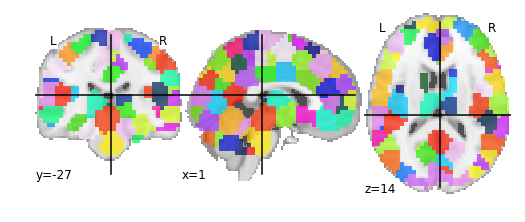

In [15]:
from nilearn import plotting
import numpy as np

plotting.plot_roi(atlas_filename)
print('Number of parcellations:' + str(np.unique(craddock_atlas.get_data()).shape[0] -1))

Great, let's load an example 4D fmri time-series for one subject

We have prepared some data especially for this tutorial. It is based on an open dataset of children and young adults. More details can be found here

And let's have a look at that 4D resting-state image

In [ ]:
fmri_filenames = data.func[0]
print('fmri timeseries are located in nifti image (4D) at: %s' %
       fmri_filenames)  # 4D data

And let's have a look at that 4D resting-state image

In [ ]:
plotting.plot_stat_map(fmri_filenames)

In [ ]:
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=5)

## Getting fancier with nilearn

nilearn was built by people doing machine learning of resting state fMRI data using sci-kit learn.

It has A LOT of functionallity beyond what we have time to teach here. Including:
+ image manipulation (smoothing, resampling)
+ algorithms (ICA and dictionary learning) for parcellating your own dataset (i.e. defining your own ROIS) 
+ timeseries extraction with many many options for filtering, detrending 
+ multiple methods for covariance esimtaiton (i.e. partial correlation, covariance, lasso..)
+ machine learning and cross validation

They also did a beautiful job of building a large set of ipython notebook tutorials to teach you about all these methods.

Go to the [the nilean website](http://nilearn.github.io/index.html) for more info.

Let's use another example to see some of the more complex things nilearn can do...

We'll start by using the data fetcher to grab a different atlas. This one (dosenbach_2010) if a set of coordinates in the brain to sample from..

In [ ]:
from nilearn import datasets

dosenbach = datasets.fetch_coords_dosenbach_2010()
print(dosenbach.description.decode())

### Using nilearn's sphere masker to extract the timeseries

nilearn has a built in function for extracting timeseries from functional files and doing a little extra signal processing at the same time!

Create small ROIs (usually spheres) at the peaks of activation clusters. In the case of large clusters, it can be useful to create ROIs for additional local maxima in order to explore multiple regions within the cluster. To ensure that the sphere only contains voxels that were truly activated, these spheres are often masked with the thresholded activation map.

In [ ]:
from nilearn import input_data

spheres_masker = input_data.NiftiSpheresMasker(
    seeds=dosenbach.rois, #the seeds are the dosenbach roi atlas
    smoothing_fwhm=4, radius=4.5, # set the radius of a sphere around the roi you want extracted
    standardize=True, # the time-series are centered and normed (mean 0, variance 1 in the time dimension)
    detrend=True, low_pass=0.1, high_pass=0.01, t_r=2.5, confound = adhd.confounds[0]) # additional signal cleaning and filtering params

timeseries = spheres_masker.fit_transform(func)

print("the shape of the timeseries is {}".format(timeseries.shape))

### Using nilearn's ConnectivityMeasure to calculate our correlation matrix

Avalable options are “correlation”, “partial correlation”, “tangent”, “covariance”, “precision” or other utilites in sci-py could be plugged in ([see here for an example](http://nilearn.github.io/auto_examples/03_connectivity/plot_multi_subject_connectome.html#sphx-glr-auto-examples-03-connectivity-plot-multi-subject-connectome-py))

Let's do partial correlation this time

In [ ]:
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

correlation_measure = ConnectivityMeasure(kind='covariance')
dosenbach_matrix = correlation_measure.fit_transform([timeseries])[0]

In [ ]:
seaborn.clustermap(dosenbach_matrix)

In [ ]:
from nilearn import plotting

coords = np.vstack((
    dosenbach.rois['x'],
    dosenbach.rois['y'],
    dosenbach.rois['z'],
)).T

plotting.plot_connectome(dosenbach_matrix, node_coords = coords, edge_threshold='98%')

## Now let's repeat the sphere's with confound cleaning

In [ ]:
from nilearn import input_data

spheres_masker = input_data.NiftiSpheresMasker(
    seeds=dosenbach.rois, #the seeds are the dosenbach roi atlas
    smoothing_fwhm=4, radius=4.5, # set the radius of a sphere around the roi you want extracted
    standardize=True, # the time-series are centered and normed (mean 0, variance 1 in the time dimension)
    detrend=True, low_pass=0.1, high_pass=0.01, t_r=2.5) # additional signal cleaning and filtering params

timeseries = spheres_masker.fit_transform(func, confounds=func_confounds)

print("the shape of the timeseries is {}".format(timeseries.shape))

In [ ]:
correlation_measure = ConnectivityMeasure(kind='covariance')
dosenbach_matrix = correlation_measure.fit_transform([timeseries])[0]
seaborn.clustermap(dosenbach_matrix)

In [ ]:
## now let's try cleaning the whole image with image.clean

In [ ]:
# image clearning inside nilearn

cleaned_func = img.clean_img(func, confounds=func_confounds, low_pass=0.1, high_pass=0.01, t_r=2.0,)

In [ ]:
nifti label masker

### Interpretability